**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.spatial.distance import cdist as cdist
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from sklearn.neighbors import KDTree
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic
%matplotlib inline

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric="minkowski"):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes_number = len(np.unique(y))
        if self.algorithm == 'kd_tree':
            self.kd_tree = KDTree(self.X_train)

    def predict(self, X):
        if self.algorithm == 'brute':
            d = pairwise_distances(X, self.X_train, self.metric)
            #d = cdist(X, self.X_train, self.metric) долго
            self.ind = d.argpartition(self.n_neighbors)[:, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            _, self.ind = self.kd_tree.query(np.array(X).astype(float),
                                             k=self.n_neighbors)
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(),
                                   1, self.y_train[self.ind])

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            d = cdist(X, self.X_train, self.metric)
            self.ind = d.argpartition(self.n_neighbors)[:, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            _, self.ind = self.kd_tree.query(np.array(X).astype(float),
                                             k=self.n_neighbors)
        return np.apply_along_axis(lambda x:
                                   np.bincount
                                   (x,
                                    minlength=self.classes_number) / self.n_neighbors,
                                   1, self.y_train[self.ind])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    test_size=0.1,
                                                    stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test)
           - clf.score(X_test, y_test)) < 0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 2.99 ms


array([2, 0, 1, 0, 0, 2, 1, 1, 0, 2, 0, 2, 2, 1, 1])

In [11]:
%time my_clf.predict(X_test)

Wall time: 997 µs


array([2, 0, 1, 0, 0, 2, 1, 1, 0, 2, 0, 2, 2, 1, 1], dtype=int64)

In [12]:
%time clf.predict_proba(X_test)

Wall time: 998 µs


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [13]:
%time my_clf.predict_proba(X_test)

Wall time: 998 µs


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

Wall time: 998 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [18]:
%time clf.predict(X_test)

Wall time: 2 ms


array([2, 2, 1, 0, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1])

In [19]:
%time my_clf.predict(X_test)

Wall time: 998 µs


array([2, 2, 1, 0, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1], dtype=int64)

In [20]:
%time clf.predict_proba(X_test)

Wall time: 1.99 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [21]:
%time my_clf.predict_proba(X_test)

Wall time: 997 µs


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
data_tok = []
t_ind = []
for ind, i in enumerate(data):
    for j in i:
        if (not j.isalpha() and not j.isdigit()):
            i = i.replace(j, ' ')
    while "  " in i:
        i = i.replace("  ", " ")
    i = list(filter(None, i.lower().split(' ')))
    if i != []:
        data_tok.append(list(filter(None, i)))
        t_ind.append(ind)

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer

In [28]:
indptr = [0]
indices = []
dat = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        dat.append(1)
    indptr.append(len(indices))
d = csr_matrix((dat, indices, indptr), dtype=int)
tg = target[t_ind].astype(int)

In [29]:
d.shape

(11004, 98749)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [30]:
col = np.where(np.sum(d.toarray(), axis=0) > 5)
dnew = d.toarray()[:, np.array(col).flatten()].astype(int)
dnew.shape

(11004, 19845)

In [31]:
kf = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Best n_neighbors: 10


Text(0, 0.5, 'score')

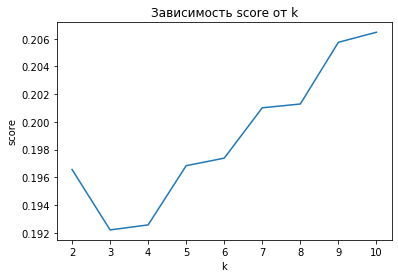

In [32]:
max_neighbors = 10
scores = []
sc = 0
max_k = 0
max_score = 0.0
for k in range(2, max_neighbors+1):
    for train_index, test_index in kf.split(dnew):
        X_train, X_test = dnew[train_index], dnew[test_index]
        y_train, y_test = tg[train_index], tg[test_index]
        clf = MyKNeighborsClassifier(n_neighbors=k,
                                   algorithm='brute', metric="euclidean")
        clf.fit(X_train, y_train)
        sc = sc + clf.score(X_test, y_test)
    scores.append(sc/3)
    if sc/3 > max_score:
        max_score = sc/3
        max_k = k
    sc = 0

print("Best n_neighbors:", max_k)
plt.plot(range(2, max_neighbors+1), scores)
plt.title('Зависимость score от k')
plt.xlabel('k')
plt.ylabel('score')


In [33]:
print(max_score)

0.2064703744093057


<p>Как изменится качество на валидации, если:<ol>

<li>Используется косинусная метрика вместо евклидовой.</li>
<li>К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)</li>
</ul></p>
<p>Сравните модели, выберите лучшую.</p>

In [34]:
tfid = TfidfTransformer()
d2 = tfid.fit_transform(d).toarray()

In [35]:
d2.shape

(11004, 98749)

In [36]:
print(d2[:100, :100])

[[-0.01583027  0.11932665  0.1326844  ...  0.          0.
   0.        ]
 [-0.00447188  0.          0.         ...  0.15719545  0.12167611
   0.17985578]
 [-0.03150807  0.02740431  0.06094406 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.02838254  0.         ...  0.          0.
   0.        ]
 [-0.01352864  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [37]:
dnew2 = d2[:, np.array(col).flatten()]
dnew2.shape
print(dnew2)

[[-0.01583027  0.11932665  0.1326844  ...  0.          0.
   0.        ]
 [-0.00447188  0.          0.         ...  0.          0.
   0.        ]
 [-0.03150807  0.02740431  0.06094406 ...  0.          0.
   0.        ]
 ...
 [-0.00610604  0.03451996  0.         ...  0.          0.
   0.        ]
 [-0.02013152  0.          0.         ...  0.          0.
   0.        ]
 [-0.00537086  0.          0.         ...  0.          0.
   0.        ]]


Best n_neighbors: 10


Text(0, 0.5, 'score')

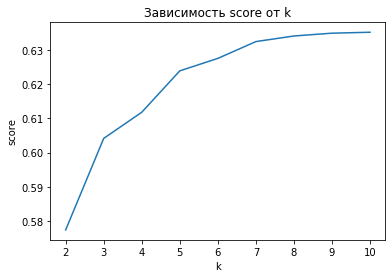

In [38]:
max_neighbors = 10
scores = []
sc = 0
max_k = 0
max_score = 0.0
for k in range(2, max_neighbors+1):
    for train_index, test_index in kf.split(dnew2):
        X_train, X_test = dnew2[train_index], dnew2[test_index]
        y_train, y_test = tg[train_index], tg[test_index]
        clf = MyKNeighborsClassifier(n_neighbors=k,
                                   algorithm='brute', metric="cosine")
        clf.fit(X_train, y_train)
        sc = sc + clf.score(X_test, y_test)
    scores.append(sc/3)
    if sc/3 > max_score:
        max_score = sc/3
        max_k = k
    sc = 0

print("Best n_neighbors:", max_k)
plt.plot(range(2, max_neighbors+1), scores)
plt.title('Зависимость score от k')
plt.xlabel('k')
plt.ylabel('score')

In [39]:
print(max_score)

0.6351326790258088


Изначально попарные расстояния я считала с помощью функции cdist, на небольших данных работает хорошо (сравнимо с стандартным классом). <p>НО в этом случае все плохо: либо программа зависла, либо просто ОЧЕНЬ долго считал.</p> Поэтому вместо этой функции я применила sklearn.metrics.pairwise_distances, она побыстрее будет.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [40]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [41]:
data_test = newsgroups['data']
target_test = newsgroups['target']

In [42]:
data_tok_test = []
t_ind_test = []
for ind, i in enumerate(data_test):
    for j in i:
        if (not j.isalpha() and not j.isdigit()):
            i = i.replace(j, ' ')
    while "  " in i:
        i = i.replace("  ", " ")
    i = list(filter(None, i.lower().split(' ')))
    if i != []:
        data_tok_test.append(list(filter(None, i)))
        t_ind_test.append(ind)

In [43]:
assert all(isinstance(row, (list, tuple)) for row in data_tok_test), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok_test), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok_test))), "please make sure that you lowercase the data and drop spaced texts"

In [44]:
indptr_test = [0]
indices_test = []
dat_test = []
vocabulary_test = {}
for d in data_tok_test:
    for term in d:
        index = vocabulary_test.setdefault(term, len(vocabulary_test))
        indices_test.append(index)
        dat_test.append(1)
    indptr_test.append(len(indices_test))
d_test = csr_matrix((dat_test, indices_test, indptr_test), dtype=int)
tg_test = target_test[t_ind_test].astype(int)

In [45]:
d_test.shape

(7309, 69203)

In [46]:
tfid = TfidfTransformer()
d2test = tfid.fit_transform(d_test).toarray()

In [47]:
d2test.shape

(7309, 69203)

In [48]:
kf = KFold(n_splits=3)
sc = 0.0
scores = []
for train_index, test_index in kf.split(d2test):
    X_train, X_test = d2test[train_index], d2test[test_index]
    y_train, y_test = tg_test[train_index], tg_test[test_index]
    clf = MyKNeighborsClassifier(n_neighbors=max_k,
                               algorithm='brute', metric="cosine")
    clf.fit(X_train, y_train)
    sc = sc + clf.score(X_test, y_test)
scores.append(sc/3)

In [49]:
scores[0]

0.6323706612996723

Он меньше, чем на train (что логично), связано с тем, что в тестовой выборке встречаются слова, которых нет в трейновой и наоборот.